In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [18]:
def calculate_anomaly_count(df, window=672, target_col='volume', 
                           lower_percentile=5, upper_percentile=95, 
                           threshold_std=3):
    """
    计算前N个窗口内异常值个数因子
    
    参数:
    df: 包含OHLC数据的DataFrame
    window: 回溯窗口大小(默认100)
    target_col: 分析的目标列(默认'volume')
    lower_percentile: 下分位数(默认5%)
    upper_percentile: 上分位数(默认95%)
    threshold_std: 异常值判断的标准差倍数(默认1.5)
    """
    # 初始化结果数组
    anomaly_count = np.zeros(len(df))
    
    # 循环计算每个时间点的异常值数量
    for i in range(window, len(df)):
        # 获取当前窗口数据
        window_data = df[target_col].iloc[i-window:i]
        
        # 计算分位数边界
        q_low = np.percentile(window_data, lower_percentile)
        q_high = np.percentile(window_data, upper_percentile)
        
        # 剔除极端值
        filtered = window_data[(window_data >= q_low) & (window_data <= q_high)]
        
        # 计算均值和标准差
        mean_val = filtered.mean()
        std_val = filtered.std()
        
        # 如果标准差为0，跳过计算
        if std_val == 0:
            anomaly_count[i] = 0
            continue
        
        # 计算异常值阈值
        upper_bound = mean_val + threshold_std * std_val
        
        # 统计当前窗口内异常值数量
        anomalies = window_data[window_data > upper_bound]
        anomaly_count[i] = len(anomalies)
    
    return pd.Series(anomaly_count, index=df.index)

# 使用默认参数计算因子
def anomaly_factor(df):
    return calculate_anomaly_count(df)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.009079
   Rank_IC (Spearman): -0.006370
📊 信息比率:
   IR: nan
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: anomaly_count_volume
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


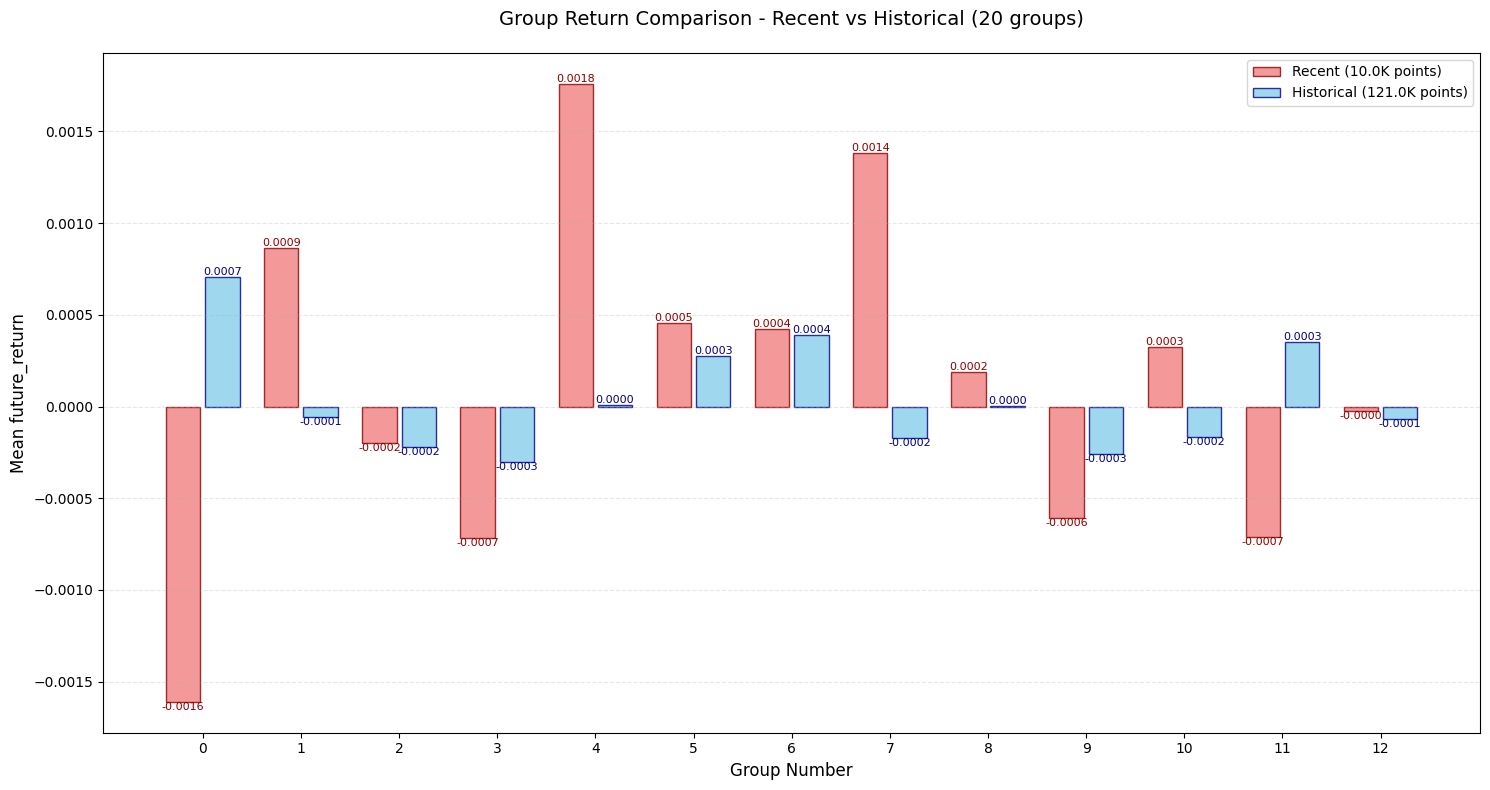

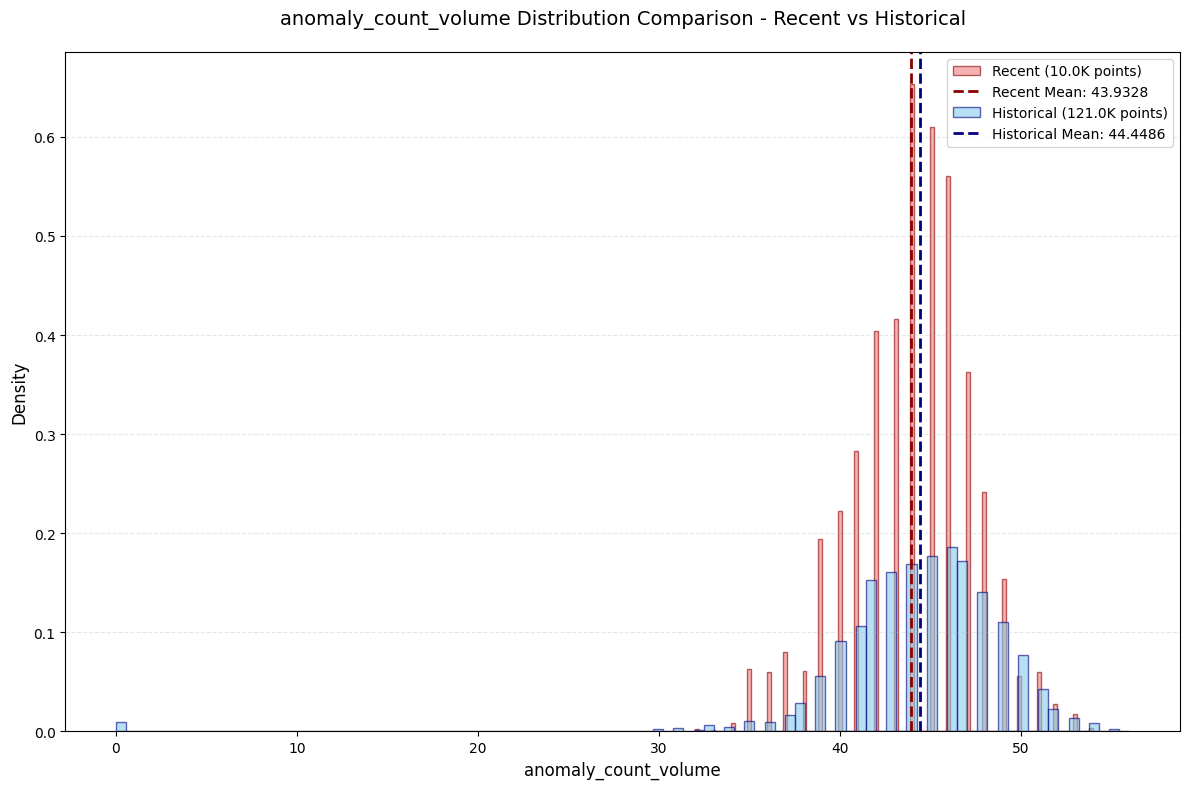

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [19]:
evaluator.set_factor(
    factor_func=anomaly_factor,
    factor_name='anomaly_count_volume'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

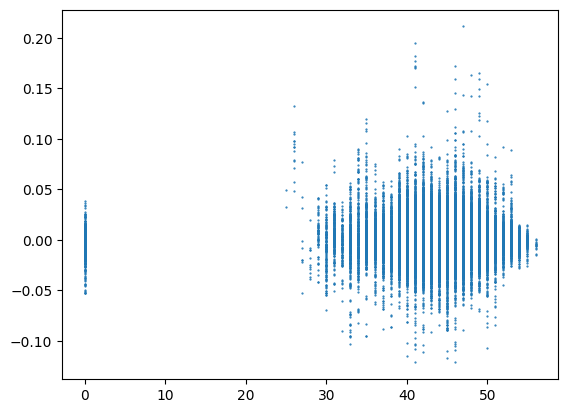

In [20]:
import matplotlib.pyplot as plt
plt.scatter(anomaly_factor(df),df['close'].pct_change(-10), s=0.3)

In [21]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.026777018552208143,
 0.004708656042537358,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.00956007776059123]

In [22]:
print(result)

{'correlation_analysis': {'IC': -0.009079384896758096, 'Rank_IC': -0.006369816892115355}, 'information_ratio': {'IR': nan, 'group_correlations': [-0.026777018552208143, 0.004708656042537358, nan, nan, nan, nan, nan, nan, nan, -0.00956007776059123], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0000  38.0000   32.4407       0.0005      0.0172   7020
1      39.0000  40.0000   39.6127      -0.0000      0.0128  10917
2      41.0000  41.0000   41.0000      -0.0003      0.0137   7866
3      42.0000  42.0000   42.0000      -0.0001      0.0121  11236
4      43.0000  43.0000   43.0000       0.0000      0.0117  11824
5      44.0000  44.0000   44.0000       0.0003      0.0112  12900
6      45.0000  45.0000   45.0000       0.0005      0.0117  13324
7      46.0000  46.0000   46.0000      -0.0001      0.0112  13870
8      47.0000  47.0000   47.0000      -